# Final Project

The project aims to develop and implement a concept as a Jupyter notebook framework for the spatio-temporal harmonisation of ERA5 reanalysis data, enabling comparison with DWD station measurements.

## Project Parts

- Conceptual: definition of data processing workflow including
    - target temporal resolution and aggregation strategy
    - definition of matched records as basic unit to enable comparison
    - spatial and temporal harmonisation between gridded ERA5 data and point-based DWD observations
    - criteria for joining the two data sources (scheme for a joined table)
- Coding: implementation of defined concept in a suitable data processing workflow 
    - collecting ERA5 reanalysis data and DWD station observations
    - preparation and harmonisation of both data according to a matched-record concept
    - generation of a combined dataset suitable for comparison and basic evaluation
    - implement basic evaluation via metrics like bias and RMSE


## Imports and Prerequisites

In [21]:
import zipfile, requests
from datetime import date, datetime, timedelta
import io
import pandas as pd
import numpy as np
from io import StringIO

import geopandas as gpd
import matplotlib.pyplot as plt
import math

### Joined Table

In [2]:
JOINT_COLUMNS = [
    "station_id",
    "date",
    "avg_obs",
    "avg_era5",
    "n_obs ",
    "coverage",
    "lat",
    "lon",
    "station_heigh_m",
    "era5_lat",
    "era5_lon",
]

joint_df = pd.DataFrame(columns=JOINT_COLUMNS)
joint_df.head()


,station_id,date,avg_obs,avg_era5,n_obs,coverage,lat,lon,station_heigh_m,era5_lat,era5_lon


### DWD Station Data Pre-Processing (Aggregation) 

In [3]:
def aggregate_dwd():
    return
    

## Access data from the DWD

In [4]:
# dictionary that stores metadata on different DWD variables

DWD_PRODUCTS = {
    "air_temperature": {
        "code": "TU",
        "column_name": "TT_TU"
    },
    "wind": {
        "code": "FF",
        "column_name": "F"
    },
    "precipitation": {
        "code": "RR",
        "column_name": "R1"
    },
}

BASE_CDC = "https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly"

In [5]:
# Generates suitable CDC URL based on given paramters 

def dwd_zip_url(variable, station_id, mode="recent"):
    if variable not in DWD_PRODUCTS:
        raise KeyError(f"Unknown variable: {variable}")

    code   = DWD_PRODUCTS[variable]["code"]
    
    if mode == "recent":
        suffix = "akt"
    else:
        suffix = "hist"

    return f"{BASE_CDC}/{variable}/{mode}/stundenwerte_{code}_{station_id}_{suffix}.zip"


In [17]:
# Downloads data from DWD CDC in RAM and stores only the wanted data in a dataframe

def download_DWD_data(
    variable, station_id, 
    date=None, 
    start_date=None, 
    end_date=None, 
    inject_missing=False,
    missing_frac=0.05, 
    random_state=42,
):

    zip_url = dwd_zip_url(variable, station_id, mode="recent")

    r = requests.get(zip_url, timeout=60)
    r.raise_for_status()

    zf = zipfile.ZipFile(io.BytesIO(r.content))
    produkt = next(
        n for n in zf.namelist()
        if n.lower().startswith("produkt_") and n.lower().endswith(".txt")
    )

    with zf.open(produkt) as f:
        df = pd.read_csv(f, sep=";")

    df.columns = (
        df.columns
          .astype(str)
          .str.strip()
          .str.replace(r"\s+", "", regex=True)
    )

    df["time"] = pd.to_datetime(df["MESS_DATUM"], format="%Y%m%d%H", errors="coerce")
    
    # replace missing value codes
    value_col = DWD_PRODUCTS[variable]["column_name"]

    # inject artificial missing values
    if inject_missing:
        rng = np.random.default_rng(random_state)

        valid_idx = df[df[value_col] != -999].index
        n_inject = int(len(valid_idx) * missing_frac)

        inject_idx = rng.choice(valid_idx, size=n_inject, replace=False)
        df.loc[inject_idx, value_col] = -999
    
    df[value_col] = df[value_col].replace([-999, -999.0], pd.NA)

    if date is not None:
        target_date = pd.to_datetime(date).date()
        mask = df["time"].dt.date == target_date
    else:
        start = pd.to_datetime(start_date)
        end = pd.to_datetime(end_date) + pd.Timedelta(days=1)
        mask = (df["time"] >= start) & (df["time"] < end)

    df_out = df.loc[mask, ["time", value_col]].copy()
    df_out = df_out.rename(columns={value_col: variable}).sort_values("time")

    return df_out

In [18]:
def download_DWD_data_multi(
    variable, 
    station_ids, 
    start_date=None, 
    end_date=None, 
    date=None,
    inject_missing=False,
):

    frames = []
    errors = []

    for sid in station_ids:
        sid_str = str(sid).zfill(5)
        try:
            df = download_DWD_data(
                variable=variable,
                station_id=sid_str,
                date=date,
                start_date=start_date,
                end_date=end_date,
                inject_missing=inject_missing,
            )

            df = df.copy()
            df["STATIONS_ID"] = sid_str

            frames.append(df)

        except Exception as e:
            errors.append((sid_str, repr(e)))

    if not frames:
        raise RuntimeError(f"No data downloaded. Errors: {errors}")

    df_all = pd.concat(frames, ignore_index=True)

    cols = ["STATIONS_ID", "time", variable]
    df_all = df_all[cols].sort_values(["STATIONS_ID", "time"]).reset_index(drop=True)

    if errors:
        print("Some stations failed:")
        for sid_str, err in errors:
            print(f"  {sid_str}: {err}")

    return df_all


### Selection of Stations

In [66]:
def find_stations(variable, mode, state, start_date, end_date):

    code = DWD_PRODUCTS[variable]["code"]
    STATION_LIST_URL = f"https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/{variable}/{mode}/{code}_Stundenwerte_Beschreibung_Stationen.txt"

    r = requests.get(STATION_LIST_URL, timeout=60)
    r.raise_for_status()
    lines = r.content.decode("latin-1").splitlines()
    
    # Keep only data lines (start with a digit)
    data_lines = [ln for ln in lines if ln.strip() and ln.lstrip()[0].isdigit()]
    
    rows = []
    for ln in data_lines:
        parts = ln.split(None, 6)  # station_id, von_datum, bis_datum, Stationshoehe, geoBreite, geoLaenge, rest
        if len(parts) < 7:
            continue
    
        station_id, von, bis, height, lat, lon, rest = parts
    
        # Split 'rest' from the right into: Stationsname, Bundesland, Abgabe
        rest_parts = rest.rsplit(None, 2)
        if len(rest_parts) != 3:
            continue
    
        name, bundesland, status = rest_parts
    
        rows.append((
            station_id,
            int(von),
            int(bis),
            float(height),
            float(lat),
            float(lon),
            name,
            bundesland,
            status
        ))
    
    stations = pd.DataFrame(
        rows,
        columns=["STATIONS_ID", "start_date", "end_date", "station_height_m", "lat", "lon", "stations_name", "State", "Abgabe"]
    )
    
    stations["STATIONS_ID"] = stations["STATIONS_ID"].astype(str).str.zfill(5)
    
    start_int = int(pd.to_datetime(start_date).strftime("%Y%m%d"))
    end_int   = int(pd.to_datetime(end_date).strftime("%Y%m%d"))
    
    stations_nrw = stations[
        (stations["State"].str.strip() == state) &
        (stations["start_date"] <= start_int) &
        (stations["end_date"] >= end_int)
    ].copy()
    
    stations_nrw = stations_nrw.sort_values("STATIONS_ID").reset_index(drop=True)
    
    #print("All stations parsed:", len(stations))
    #print(f"{state} stations covering full period:", len(stations_nrw))

    return stations_nrw

In [67]:
find_stations(
    variable="air_temperature",
    mode="recent",
    state = "Nordrhein-Westfalen",
    start_date = "2026-01-01",
    end_date = "2026-01-24"
).head()

,STATIONS_ID,start_date,end_date,station_height_m,lat,lon,stations_name,State,Abgabe
0,00390,20040701,20260127,611.0,50.9837,8.3683,"Berleburg, Bad-Stünzel",Nordrhein-Westfalen,Frei
1,00555,20080101,20260127,110.0,51.5026,7.2289,Bochum,Nordrhein-Westfalen,Frei
2,00603,20010403,20260127,147.0,50.7293,7.2040,Königswinter-Heiderhof,Nordrhein-Westfalen,Frei
3,00617,20040601,20260127,47.0,51.8730,6.8863,Borken in Westfalen,Nordrhein-Westfalen,Frei
4,01078,19760301,20260127,37.0,51.2960,6.7686,Düsseldorf,Nordrhein-Westfalen,Frei


C:\Users\Nils\anaconda3\Lib\site-packages\pyogrio\core.py:35: RuntimeWarning: Could not detect GDAL data files. Set GDAL_DATA environment variable to the correct path.
  _init_gdal_data()


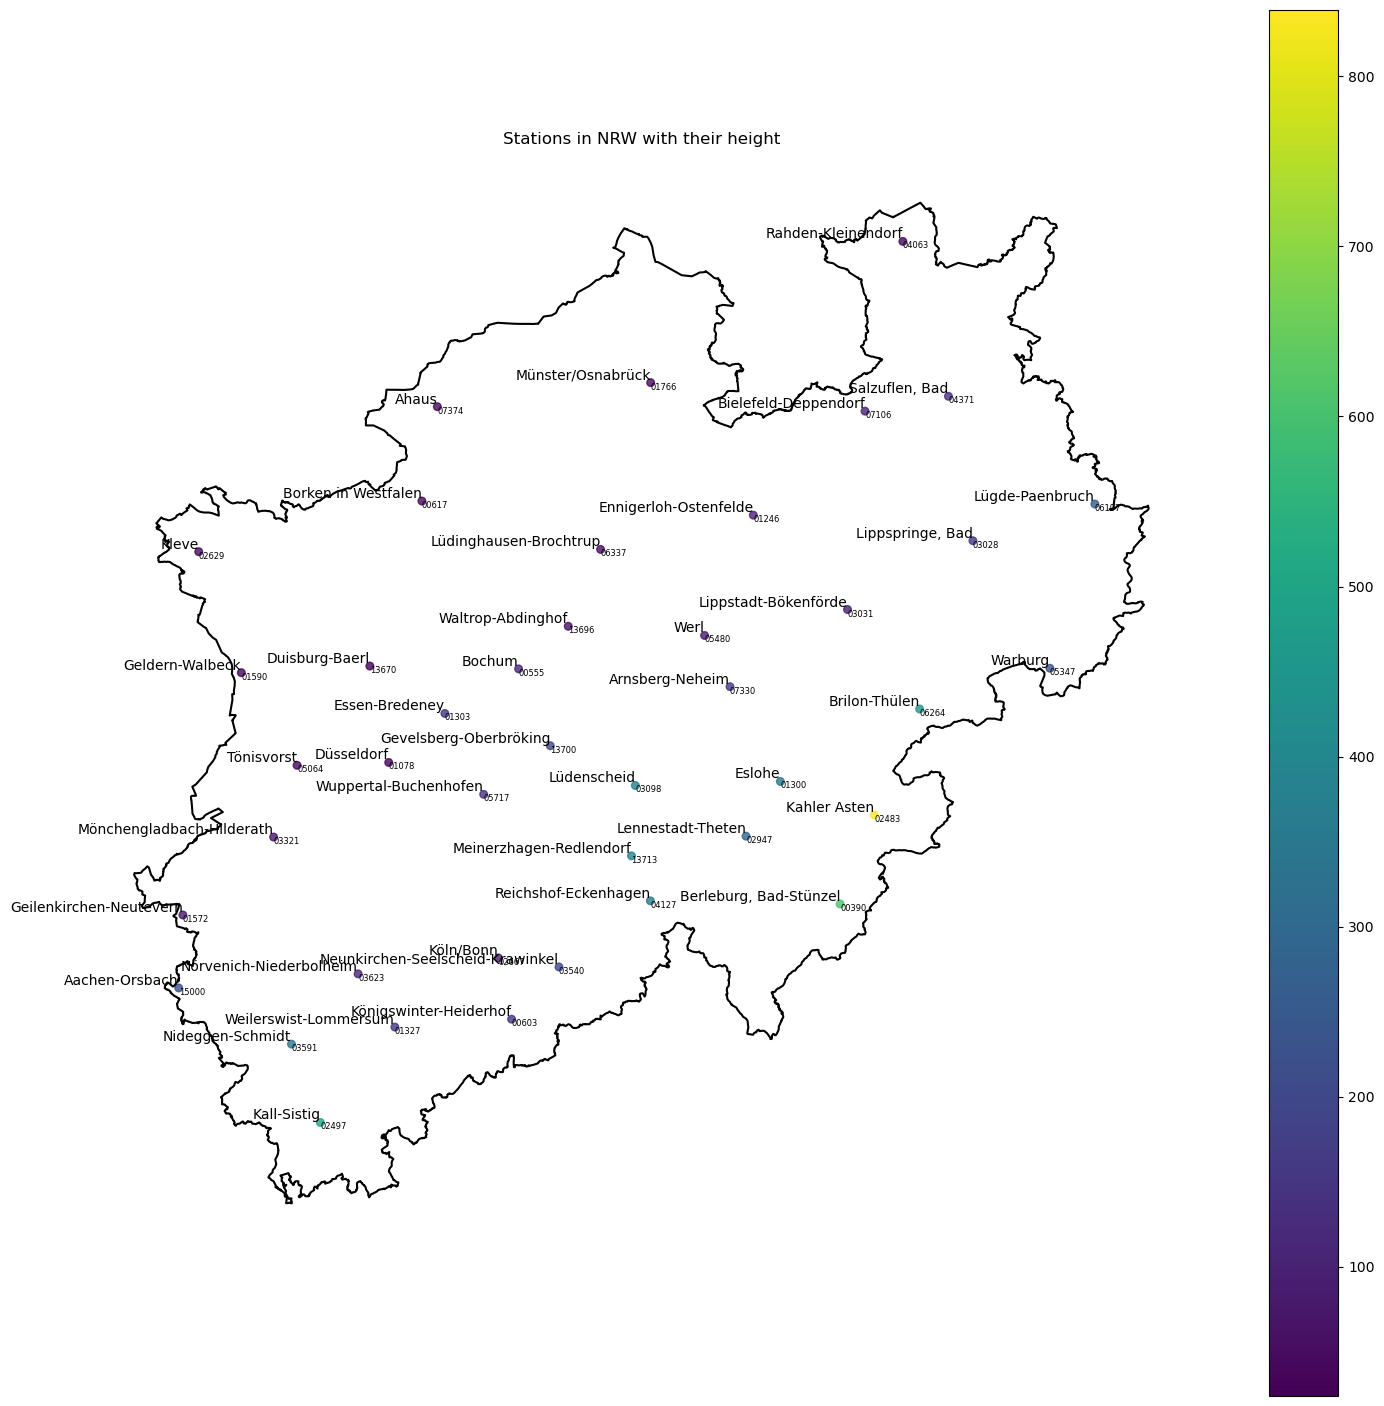

In [72]:
stations_df = find_stations(
        variable="air_temperature",
        mode="recent",
        state="Nordrhein-Westfalen",
        start_date="2026-01-01",
        end_date="2026-01-24",
    )

stations_gdf = gpd.GeoDataFrame(
    stations_df,
    geometry=gpd.points_from_xy(
        stations_df.lon, 
        stations_df.lat
    ),
    crs="EPSG:4326"
)

# Load NRW borders from GADM v4.1
gadm_zip = "https://geodata.ucdavis.edu/gadm/gadm4.1/shp/gadm41_DEU_shp.zip"
de_states = gpd.read_file(f"zip+{gadm_zip}!gadm41_DEU_1.shp")
nrw = de_states[de_states["NAME_1"] == "Nordrhein-Westfalen"]

nrw = nrw.to_crs(stations_gdf.crs)

fig, ax = plt.subplots(figsize=(18, 18))

# plot NRW borders
nrw.boundary.plot(
    ax=ax,
    linewidth=1.5,
    color="black",
    aspect="equal"
)

# plot stations and color them regarding their height
stations_gdf.plot(
    ax=ax,
    column="station_height_m",        # 👈 Höhen-Spalte
    cmap="viridis",         # Farbskala
    markersize=30,
    legend=True,            # Farblegende
    alpha=0.8
)

for _, row in stations_gdf.iterrows():
    ax.text(
        row.geometry.x,
        row.geometry.y,
        str(row["STATIONS_ID"]),
        fontsize=6,
        ha="left",
        va="top"
    )

for _, row in stations_gdf.iterrows():
    ax.text(
        row.geometry.x,
        row.geometry.y,
        str(row["stations_name"]),
        fontsize=10,
        ha="right",
        va="bottom"
    )

ax.set_title("Stations in NRW with their height")
ax.set_axis_off()
plt.show()

In [ ]:
df = download_DWD_data(
    variable = "air_temperature",
    station_id = "02667",
    start_date="2026-01-01",
    end_date="2026-01-20",   
)

df["time"] = pd.to_datetime(df["time"])
df["hour"] = df["time"].dt.hour

missing_by_hour = (
    df.groupby("hour")["air_temperature"]
      .apply(lambda s: s.isna().mean())
      .reindex(range(24), fill_value=0.0) 
)

print("Missingness rate by hour (0..23):")
print(missing_by_hour)

plt.figure(figsize=(8, 4))
availability_by_hour.plot(kind="bar")
plt.xlabel("Hour of day")
plt.ylabel("Availability rate")
plt.title("Missingness per hour")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

In [ ]:
df = download_DWD_data(
    variable = "air_temperature",
    station_id = "02667",
    start_date="2026-01-01",
    end_date="2026-01-20",   
)

df["time"] = pd.to_datetime(df["time"])
df["hour"] = df["time"].dt.hour

availability_by_hour = (
    df.groupby("hour")["air_temperature"]
      .apply(lambda s: s.notna().mean())
      .reindex(range(24), fill_value=0.0)
)

print("Availability rate by hour (0..23):")
print(availability_by_hour)

plt.figure(figsize=(8, 4))
availability_by_hour.plot(kind="bar")
plt.xlabel("Hour of day")
plt.ylabel("Availability rate")
plt.title("Hourly data availability per hour (single station)")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

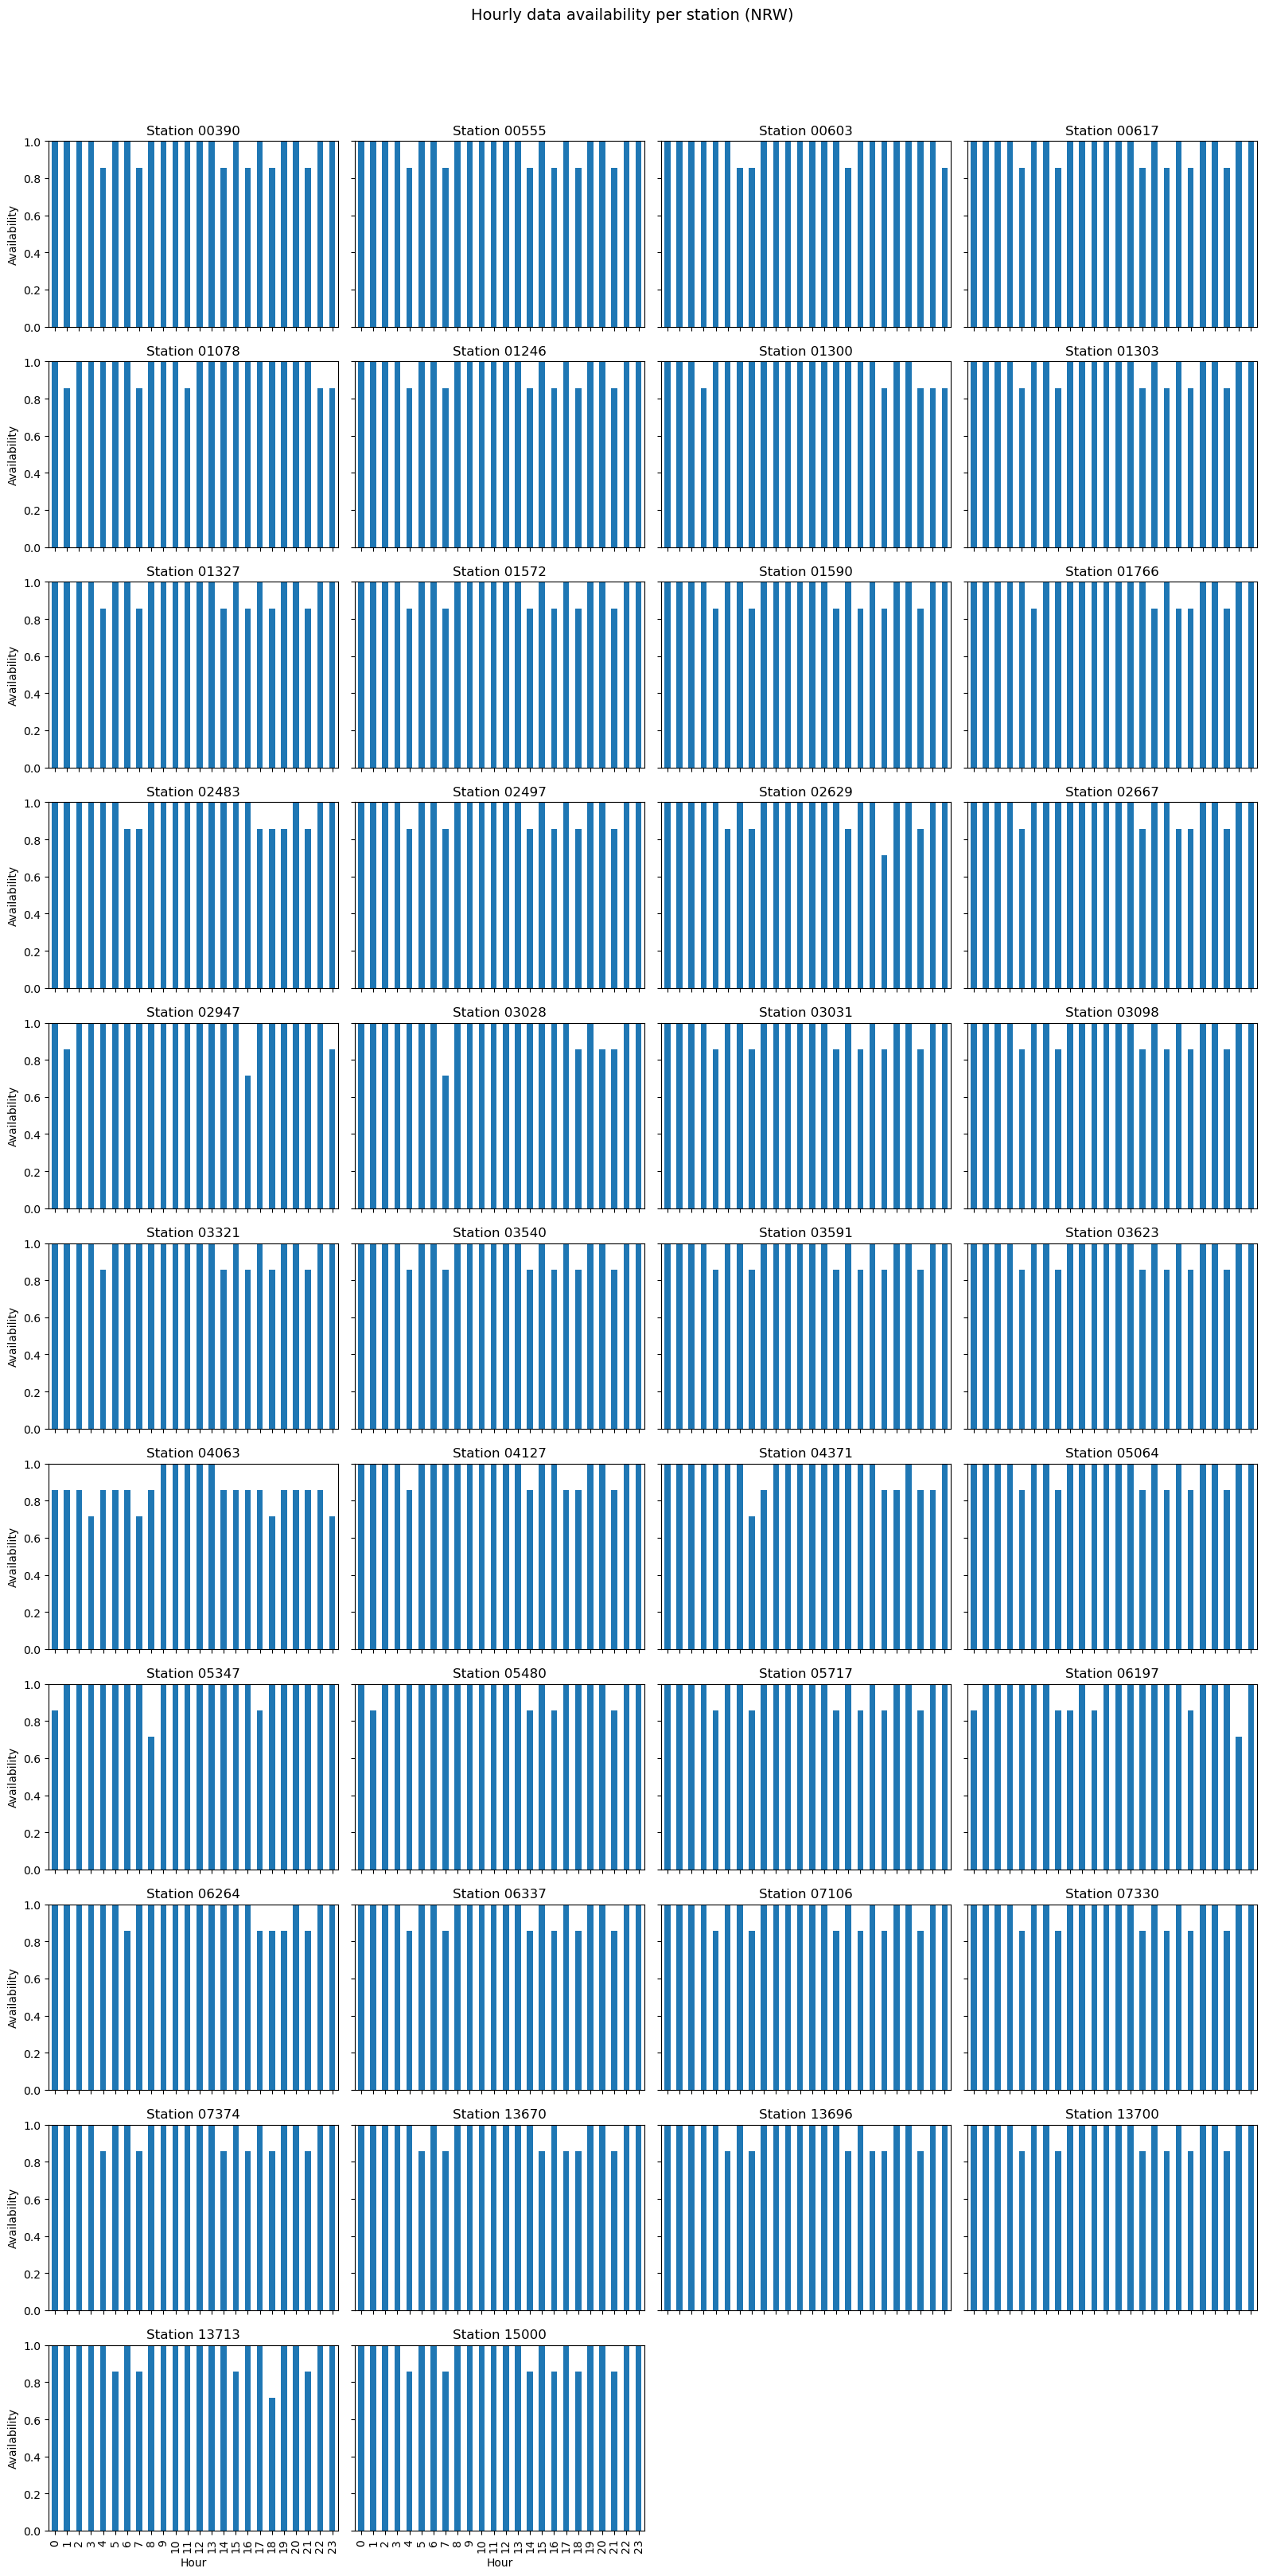

In [73]:
station_ids = stations_df["STATIONS_ID"].tolist()

df_hourly_all = download_DWD_data_multi(
    variable="air_temperature",
    station_ids=station_ids,
    start_date="2026-01-01",
    end_date="2026-01-07",
    inject_missing=True,
)

df_hourly_all["time"] = pd.to_datetime(df_hourly_all["time"])
df_hourly_all["hour"] = df_hourly_all["time"].dt.hour

stations = sorted(df_hourly_all["STATIONS_ID"].unique())
n_stations = len(stations)

# subplot layout
n_cols = 4
n_rows = math.ceil(n_stations / n_cols)

fig, axes = plt.subplots(
    n_rows, n_cols,
    figsize=(4 * n_cols, 3 * n_rows),
    sharey=True,
    sharex=True
)

axes = axes.flatten()

for ax, station_id in zip(axes, stations):
    df_s = df_hourly_all[df_hourly_all["STATIONS_ID"] == station_id]

    availability_by_hour = (
        df_s.groupby("hour")["air_temperature"]
            .apply(lambda s: s.notna().mean())
            .reindex(range(24), fill_value=0.0)
    )

    availability_by_hour.plot(kind="bar", ax=ax)
    ax.set_title(f"Station {station_id}")
    ax.set_ylim(0, 1)
    ax.set_xlabel("Hour")
    ax.set_ylabel("Availability")

# hide unused subplots
for ax in axes[len(stations):]:
    ax.axis("off")

fig.suptitle("Hourly data availability per station (NRW)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## Testing

In [23]:
station_ids = ["00555","00603","00617","01078","01246","01300","01303","01327","01572","01590","01766","02483","02497","02629","02667","02947","03028","03031","03098"]
df_hourly_all = download_DWD_data_multi(
    variable="air_temperature",
    station_ids=station_ids,
    start_date="2026-01-01",
    end_date="2026-01-07",
    inject_missing=True,
)
df_hourly_all.head()

,STATIONS_ID,time,air_temperature
0,00555,2026-01-01 00:00:00,2.2
1,00555,2026-01-01 01:00:00,2.3
2,00555,2026-01-01 02:00:00,2.2
3,00555,2026-01-01 03:00:00,2.1
4,00555,2026-01-01 04:00:00,<NA>


In [22]:
download_DWD_data(
    variable="air_temperature",
    station_id="00555",
    start_date="2026-01-01",
    end_date="2026-01-07",
    inject_missing=True,
).head()

,time,air_temperature
12552,2026-01-01 00:00:00,2.2
12553,2026-01-01 01:00:00,2.3
12554,2026-01-01 02:00:00,2.2
12555,2026-01-01 03:00:00,2.1
12556,2026-01-01 04:00:00,<NA>
